In [1]:
! pip install -q 'git+https://github.com/Maluuba/nlg-eval.git@master'

In [2]:
! nlg-eval --setup

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Installing to /root/.cache/nlgeval
In case of incomplete downloads, delete the directory and run `nlg-eval --setup /root/.cache/nlgeval' again.
glove2word2vec.py: 100%|█████████████████| 1.00/1.00 [00:00<00:00, 493 chunks/s]


In [3]:
import os
import numpy as np
import pandas as pd
import json
import torch, torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import math

from nlgeval import compute_individual_metrics

# **SINGLE STOP HYPERPARAMETERS**

In [4]:
#Hyperparameters
embed_size = 300
hidden_size = 512
enc_dim = 2048
att_dim = 49
batch_size = 80
train_embed = False
train_CNN = False
lr_enc = 1e-5
lr_dec = 5e-4
num_layers = 1
num_epochs = 10
freq_threshold = 5

In [5]:
os.chdir('/kaggle/input/karpathy-splits')
f = open('dataset_flickr30k.json')
dataset = json.load(f)

In [7]:
train_imgs = list()
train_labels = list()
val_imgs = list()
val_labels = list()
test_imgs = list()
test_labels = list()
all_labels = list()

# **NOW LETS DO TRAIN-TEST-VALIDTION SPLIT**

In [8]:
for img in dataset['images']:   
    for sentence in img['sentences']:
        
        if img['split'] == 'train':
            
                train_imgs.append(img['filename'])
                train_labels.append(sentence['tokens'])
                all_labels.append(sentence['tokens'])

                
        if img['split'] == 'test':
            
                test_imgs.append(img['filename'])
                test_labels.append(sentence['tokens'])
                all_labels.append(sentence['tokens'])
    
            
        if img['split'] == 'val':
                 
                val_imgs.append(img['filename'])
                val_labels.append(sentence['tokens'])
                all_labels.append(sentence['tokens'])

In [10]:
dict_tokens = dict()
imgs_idx = dict()
idx_imgs = dict()

for idx, img in enumerate(dataset['images']):
    dict_tokens[idx] = [sentence['tokens'] for sentence in img['sentences']]   
    imgs_idx[img['filename']] = idx
    idx_imgs[idx] = img['filename']

In [11]:
class Vocabulary:
    
    def __init__(self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
    
        print('Start building vocabulary!')
        for sentence in sentence_list: 
            for word in sentence:

                if word not in frequencies:
                    frequencies[word]=1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word]  = idx
                    self.itos[idx] = word
                    idx += 1

        print('Vocabulary built!')
  
    def numericalize(self, tokenized_text):

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

class FlickrDataset(Dataset):
    def __init__(self, root_dir, imgs, labels, vocab, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms

        self.imgs = imgs
        self.captions = labels

        self.vocab = vocab

    def __len__(self):
        return (len(self.imgs))

    def __getitem__(self, index):
        
        caption = self.captions[index]
        img_id = self.imgs[index]

        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return (img, torch.tensor(numericalized_caption), torch.tensor([imgs_idx[img_id]]))

class MyCollate:
    
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim = 0)
        img_ids = [item[2].unsqueeze(0) for item in batch]
        img_ids = torch.cat(img_ids, dim = 0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = False, padding_value = self.pad_idx)

        return imgs, targets, img_ids
  

def get_loader(root_folder, 
               imgs, 
               labels,
               vocab,
               transforms, 
               batch_size = 32, 
               shuffle=True):
    dataset = FlickrDataset(root_folder, imgs, labels, vocab, transforms)
    print('Dataset made!')
    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        collate_fn = MyCollate(pad_idx = dataset.vocab.stoi["<PAD>"])
     )

    return loader, dataset

# **BUILD VOCABULARY ON THE CAPTIONS**

In [12]:
vocab = Vocabulary(freq_threshold)
vocab.build_vocabulary(all_labels)

vocab_size = len(vocab)

Start building vocabulary!
Vocabulary built!


In [14]:
print(vocab_size)

7652


IMAGE TRANSFORMATION:
1. RESIZE TO 224x224
1. NORMALIZE

In [15]:
transformations = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

In [16]:
os.chdir('/kaggle/input/flickr-image-dataset/flickr30k_images')

# **LOAD TRAIN,TEST AND VALIDATION DATA**

In [17]:
train_loader , train_dataset = get_loader(
        root_folder="flickr30k_images",
        imgs=train_imgs,
        labels=train_labels,
        vocab=vocab,
        transforms=transformations,
        batch_size=batch_size
    )
val_loader , val_dataset = get_loader(
        root_folder="flickr30k_images",
        imgs=val_imgs,
        labels=val_labels,
        vocab=vocab,
        transforms=transformations,
        batch_size=batch_size
    )

Dataset made!
Dataset made!


In [18]:
test_loader , test_dataset = get_loader(
        root_folder="flickr30k_images",
        imgs=test_imgs,
        labels=test_labels,
        vocab=vocab,
        transforms=transformations,
        batch_size=batch_size
    )

Dataset made!


# **LOAD GLOVE EMBEDDING**

In [20]:
words = []
glove = {}
with open(f'/kaggle/input/glove6b/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word) 
        vect = np.array(line[1:]).astype(np.float)
        glove[word] = vect

In [21]:
weights_matrix = np.zeros((vocab_size, embed_size))

for key, index in vocab.stoi.items():
    
    if key in glove:
        weights_matrix[index] = glove[key]
    
    else:
        weights_matrix[index] = np.random.normal(scale=0.6, size=(embed_size, ))

**MODEL STRUCTURE**
1. ENCODER: RESNET
1. DECODER: LSTM WITH ATTENTION**

In [22]:
class EncoderCNN(nn.Module):
    def __init__(self, enc_dim, embed_size, hidden_size):
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet101(pretrained = True)
        all_modules = list(resnet.children())
        modules = all_modules[:-2]
        self.resnet = nn.Sequential(*modules) 
        self.avgpool = nn.AvgPool2d(7)
        self.V_affine = nn.Linear(enc_dim, hidden_size)
        self.vg_affine = nn.Linear(enc_dim, embed_size)
        self.fine_tune()
       
    def forward(self, images):
        encoded_image = self.resnet(images)
        batch_size = encoded_image.shape[0]
        features = encoded_image.shape[1]
        num_pixels = encoded_image.shape[2] * encoded_image.shape[3]
        global_features = self.avgpool(encoded_image).view(batch_size, -1)
        global_features = F.relu(self.vg_affine(global_features))
        enc_image = encoded_image.permute(0, 2, 3, 1)  
        enc_image = enc_image.view(batch_size,num_pixels,features)
        enc_image = F.relu(self.V_affine(enc_image))
  
        return enc_image, global_features

    def fine_tune(self, train_CNN = False):
        
        if not train_CNN:
            for param in self.resnet.parameters():
                param.requires_grad = False
                        
        else:
            for module in list(self.resnet.children())[len(list(self.resnet.children()))-1:]:    #1 layer only. len(list(resnet.children())) = 8
                for param in module.parameters():
                    param.requires_grad = True 

In [23]:
class AdaptiveLSTMCell(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super(AdaptiveLSTMCell, self).__init__()
        self.lstm_cell = nn.LSTMCell(embed_size, hidden_size)
        self.x_affine = nn.Linear(embed_size, hidden_size)
        self.h_affine = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, inp, states):
        h_prev, m_prev = states
        h_t, m_t = self.lstm_cell(inp, (h_prev, m_prev))
        g_t = torch.sigmoid(self.x_affine(inp) + self.h_affine(h_prev))
        s_t = g_t*(torch.tanh(m_t))
        
        return s_t, h_t, m_t

In [24]:
class AdaptiveAttention(nn.Module):
    def __init__(self, hidden_size, att_dim):
        super(AdaptiveAttention, self).__init__()
        self.v_affine = nn.Linear(hidden_size, att_dim)
        self.h_affine = nn.Linear(hidden_size, hidden_size)
        self.h_att = nn.Linear(hidden_size, att_dim)
        self.s_affine = nn.Linear(hidden_size, hidden_size)
        self.s_att = nn.Linear(hidden_size, att_dim)
        self.wh_affine = nn.Linear(att_dim, 1)
        self.c_hidden = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, V, h_t, s_t):
        num_pixels = V.shape[1]
        v_att = self.v_affine(V)
        h_affine = F.relu(self.h_affine(h_t))
        h_att = self.h_att(h_affine)
        h_att_r = h_att.unsqueeze(1).expand(h_att.size(0), num_pixels, h_att.size(1)) 
        
        z_t = self.wh_affine(torch.tanh(v_att + h_att_r)).squeeze(2)
        alpha_t = F.softmax(z_t, dim = 1)
        c_t = torch.sum((alpha_t.unsqueeze(2).expand(V.size(0), num_pixels, V.size(2)))*V, dim = 1)
        
        s_affine = F.relu(self.s_affine(s_t))
        s_att = self.s_att(s_affine)
        z_hat_t = torch.cat((z_t, self.wh_affine(torch.tanh(s_att + h_att))), dim = 1)
        alpha_hat_t = F.softmax(z_hat_t, dim = 1)
        beta_t = alpha_hat_t[:,-1].view(alpha_hat_t.size(0), -1)
        c_hat_t = beta_t*s_t + (1-beta_t)*c_t   
        out_l = c_hat_t + h_affine
        
        return out_l
        
     
        

In [25]:
class DecoderLSTMAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, att_dim, vocab_size, train_embed = False):
        super(DecoderLSTMAttention, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(p=0.5)
        
        if not train_embed:  
            self.embed.load_state_dict({'weight': torch.tensor(weights_matrix)})
            
        self.vocab_size = vocab_size
        self.adaptive_lstm = AdaptiveLSTMCell(embed_size*2, hidden_size)
        self.adaptive_att = AdaptiveAttention(hidden_size, att_dim)
        self.p_affine = nn.Linear(hidden_size, vocab_size)
        self.fine_tune(train_embed)
    
    def init_hidden_states(self, batch_size, hidden_size):
        h_0 = torch.zeros((batch_size, hidden_size))
        m_0 = torch.zeros((batch_size, hidden_size))
        
        return h_0, m_0
        
    def forward(self, V, vg, captions, cap_len, device = 'cpu'):
        
        inp = self.embed(captions)
        h_0, m_0 = self.init_hidden_states(V.size(0), V.size(2))        
        states = h_0.to(device), m_0.to(device)
        predictions = torch.zeros((inp.size(0), inp.size(1), self.vocab_size)).to(device)
        
        for timestep in range(cap_len):
            
            x_t = torch.cat((vg, inp[timestep]), dim = 1)     
            s_t, h_t, m_t = self.adaptive_lstm(x_t, states)
            states = (h_t, m_t)
            out_l = self.adaptive_att(V, h_t, s_t)
            output = self.p_affine(self.dropout(out_l))
            predictions[timestep, :, :] = output
            
        return predictions
    
    def fine_tune(self, train_embed = False): 
        self.embed.weight.requires_grad = train_embed

In [26]:
def pred(inp, V, vg, states, decoder):
    
    inp_c = torch.cat((vg, inp), dim = 1)
    h_t, m_t = states
    s_t, h_t, m_t = decoder.adaptive_lstm(inp_c, states)
    states = (h_t, m_t)
    out_l = decoder.adaptive_att(V, h_t, s_t)
    output = decoder.p_affine(decoder.dropout(out_l))
    output = F.softmax(output, dim = 1)
    
    return output.view(output.size(1)).detach().cpu().numpy(), states
    
def caption_image_beam(image, vocabulary, encoder, decoder, device = 'cpu', k = 10, max_length=50):
    result_caption = []

    with torch.no_grad():
        V, vg = encoder(image)
        states = (torch.zeros((1, V.size(2))).to(device), torch.zeros((1, V.size(2))).to(device))
        sequences = [[list(), 0.0, states]]
        inp = vocabulary.stoi['<SOS>']

        for _ in range(max_length):
            
            all_candidates = list()
            
            for i in range(len(sequences)):
                seq, score, states = sequences[i]
                
                if len(seq) != 0:
                    inp = seq[-1]
                    
                    if vocabulary.itos[inp] == "<EOS>":
                        all_candidates.append(sequences[i])
                        continue
                        
                inp = decoder.embed(torch.tensor([inp]).to(device))
                    
                predictions, states = pred(inp, V, vg, states, decoder)
                
                word_preds = np.argsort(predictions)[-k:]
                
                for j in word_preds:
                    candidate = (seq + [j], score - math.log(predictions[j]), states)
                    all_candidates.append(candidate)
                    
            ordered = sorted(all_candidates, key=lambda tup:tup[1]/(len(tup[0])))
            sequences = ordered[:k]     
            
    output_arr = sequences[0][0]
            
    if vocabulary.itos[sequences[0][0][-1]] == '<EOS>':
        output_arr = sequences[0][0][:-1]
        
    if vocabulary.itos[sequences[0][0][0]] == '<SOS>':
        output_arr = output_arr[1:]    
        
    return [vocabulary.itos[idx] for idx in output_arr]

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
criterion = nn.CrossEntropyLoss(ignore_index = vocab.stoi["<PAD>"])
enc = EncoderCNN(enc_dim, embed_size, hidden_size).to(device)
dec = DecoderLSTMAttention(embed_size, hidden_size, att_dim, vocab_size, train_embed).to(device)
optim_enc = optim.Adam(enc.parameters(), lr = lr_enc, betas = (0.8, 0.999))
optim_dec = optim.Adam(dec.parameters(), lr = lr_dec, betas = (0.8, 0.999))

In [29]:
val_iter = iter(val_loader)
val_imgs, val_captions, val_img_ids = next(val_iter)


val_imgs = val_imgs.to(device)
val_captions = val_captions.to(device)


Epoch [1/10] Batch [1/1813] Training loss: 8.96642780303955 Validation loss: 8.851292610168457 Cumulative BLEU Score: 0 CIDEr Score: 0.0 METEOR Score: 0.00860215053763441 ROUGE_L: 0.0 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [1/10] Batch [601/1813] Training loss: 3.7936761379241943 Validation loss: 4.1628336906433105 Cumulative BLEU Score: 3.9762711149656038e-78 CIDEr Score: 0.0 METEOR Score: 0.10893155328775762 ROUGE_L: 0.3065326633165829 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: a group of people are standing in front of a building




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [1/10] Batch [1201/1813] Training loss: 3.5379366874694824 Validation loss: 3.7803168296813965 Cumulative BLEU Score: 3.9762711149656038e-78 CIDEr Score: 0.0 METEOR Score: 0.10893155328775762 ROUGE_L: 0.3065326633165829 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: a group of people are standing in front of a building




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [1/10] Batch [1801/1813] Training loss: 3.2955169677734375 Validation loss: 3.6161582469940186 Cumulative BLEU Score: 3.9762711149656038e-78 CIDEr Score: 0.0 METEOR Score: 0.10893155328775762 ROUGE_L: 0.3065326633165829 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: a group of people are standing in front of a store




/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [2/10] Batch [1/1813] Training loss: 3.5110836029052734 Validation loss: 3.612149953842163 Cumulative BLEU Score: 3.9762711149656038e-78 CIDEr Score: 0.0 METEOR Score: 0.10893155328775762 ROUGE_L: 0.3065326633165829 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: a group of people are standing in front of a store


Epoch [2/10] Batch [601/1813] Training loss: 3.502248525619507 Validation loss: 3.4823830127716064 Cumulative BLEU Score: 0.3168053533839811 CIDEr Score: 0.0 METEOR Score: 0.17857901950752877 ROUGE_L: 0.4666666666666668 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: a man in a white shirt is standing in front of a crowd of people


Epoch [2/10] Batch [1201/1813] Training loss: 3.3506622314453125 Validation loss: 3.426964044570923 Cumulative BLEU Score: 0.3168053533839811 CIDEr Score: 0.0 METEOR Scor

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [8/10] Batch [1201/1813] Training loss: 2.617748260498047 Validation loss: 3.0945699214935303 Cumulative BLEU Score: 7.505697654413981e-155 CIDEr Score: 0.0 METEOR Score: 0.12972484326497252 ROUGE_L: 0.3223249669749009 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: a man and a woman are standing in front of a food stand


Epoch [8/10] Batch [1801/1813] Training loss: 2.8095791339874268 Validation loss: 3.071561336517334 Cumulative BLEU Score: 0.21911033973347857 CIDEr Score: 0.0 METEOR Score: 0.2106259927027577 ROUGE_L: 0.4929292929292929 

Ground truth: a group of arabic looking men walking threw the city two of the men are selling some kind of meat

Predicted Caption: a man in a white shirt and a woman in a white shirt are walking down the street


Epoch [9/10] Batch [1/1813] Training loss: 2.576687812805176 Validation loss: 3.0774950981140137 Cumulative BLEU Score: 0.3168053533839811 CIDEr S

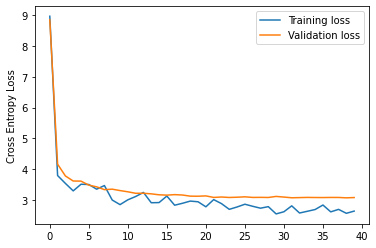

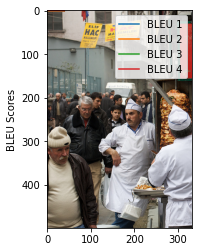

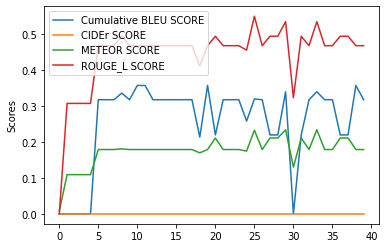

In [30]:
train_losses = list()
val_losses = list()
cumulative_bleu_scores = list()
cider_scores = list()
meteor_scores = list()
rougel_scores = list()
bleu1_scores = list()
bleu2_scores = list()
bleu3_scores = list()
bleu4_scores = list()

for epoch in range(num_epochs):
    
    if (epoch+1) >= 21 and train_CNN == False:
        train_CNN = True
        enc.fine_tune(True)
        
    for batch_idx, (imgs, captions, img_ids) in enumerate(train_loader):

        enc.train()
        dec.train()
                
        imgs = imgs.to(device)
        captions = captions.to(device)

        enc_imgs, global_features = enc(imgs)
        outputs = dec(enc_imgs, global_features, captions[:-1], captions[:-1].size(0), device)

        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[1:].reshape(-1))
        
                
        optim_enc.zero_grad()
        optim_dec.zero_grad()
        loss.backward()
                
        optim_enc.step()             
        optim_dec.step()

        if batch_idx%600 == 0:
            
            with torch.no_grad():
                
                enc.eval()
                dec.eval()
                
                

                enc_val_imgs, global_val_features = enc(val_imgs)
                val_outputs = dec(enc_val_imgs, global_val_features, val_captions[:-1], val_captions[:-1].size(0), device)

                val_loss = criterion(val_outputs.reshape(-1, val_outputs.shape[2]), val_captions[1:].reshape(-1))
                
                val_losses.append(val_loss.item())
                train_losses.append(loss.item())
                
                val_img_ids_new = val_img_ids.squeeze(1).numpy()
                
                #r_set = np.arange(batch_size)
                
                #np.random.shuffle(r_set)
                
                #index = r_set[0]
                index = 0
                val_img = val_imgs[index]
                #val_img = val_imgs
                candidate = caption_image_beam(val_img.unsqueeze(0), vocab, enc, dec, device)
                ref_tokens = dict_tokens[val_img_ids_new[index]]
                cumulative_bleu_score = sentence_bleu(ref_tokens, candidate, weights=(0.25, 0.25, 0.25, 0.25))
                    
                hyp = ' '.join(candidate)
                refs = list()
                    
                for sentence in ref_tokens:
                    ref = ' '.join(sentence)
                    refs.append(ref)
                    
                metrics = compute_individual_metrics(refs, hyp)
                
                #np.random.shuffle(refs)
                
                bleu1_scores.append(metrics['Bleu_1'])
                bleu2_scores.append(metrics['Bleu_2'])
                bleu3_scores.append(metrics['Bleu_3'])
                bleu4_scores.append(metrics['Bleu_4'])
                cider_scores.append(metrics['CIDEr'])
                cumulative_bleu_scores.append(cumulative_bleu_score)
                rougel_scores.append(metrics['ROUGE_L'])
                meteor_scores.append(metrics['METEOR'])
                
                pil_img = Image.open(os.path.join('flickr30k_images', idx_imgs[val_img_ids_new[index]])).convert("RGB")
                plt.imshow(np.asarray(pil_img))
                
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Training loss: {loss.item()} Validation loss: {val_loss.item()} Cumulative BLEU Score: {cumulative_bleu_score} CIDEr Score: {metrics['CIDEr']} METEOR Score: {metrics['METEOR']} ROUGE_L: {metrics['ROUGE_L']} \n")
                print(f"Ground truth: {refs[0]}\n")
                print(f"Predicted Caption: {hyp}\n\n")
    
        if batch_idx == (len(train_loader) - 1):
            torch.save(enc.state_dict(), f'/kaggle/working/encoder_{freq_threshold}_{batch_size}_{hidden_size}_{epoch+1}.pth')
            torch.save(dec.state_dict(), f'/kaggle/working/decoder_{freq_threshold}_{batch_size}_{hidden_size}_{epoch+1}.pth')
    

plt.figure(0)
plt.plot(train_losses, label = 'Training loss')
plt.plot(val_losses, label = 'Validation loss')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.savefig(f'/kaggle/working/{freq_threshold}_{batch_size}_{hidden_size}_{num_epochs}_losses.png')

plt.figure(1)
plt.plot(bleu1_scores, label = 'BLEU 1')
plt.plot(bleu2_scores, label = 'BLEU 2')
plt.plot(bleu3_scores, label = 'BLEU 3')
plt.plot(bleu4_scores, label = 'BLEU 4')
plt.ylabel('BLEU Scores')
plt.legend()
plt.savefig(f'/kaggle/working/{freq_threshold}_{batch_size}_{hidden_size}_{num_epochs}_bleu_scores.png')
        
plt.figure(2)
plt.plot(cumulative_bleu_scores, label = 'Cumulative BLEU SCORE')
plt.plot(cider_scores, label = 'CIDEr SCORE')
plt.plot(meteor_scores, label = 'METEOR SCORE')
plt.plot(rougel_scores, label = 'ROUGE_L SCORE')
plt.ylabel('Scores')
plt.legend()
plt.savefig(f'/kaggle/working/{freq_threshold}_{batch_size}_{hidden_size}_{num_epochs}_scores.png')

In [31]:
enc = EncoderCNN(enc_dim, embed_size, hidden_size).to(device)
dec = DecoderLSTMAttention(embed_size, hidden_size, att_dim, vocab_size, train_embed).to(device)
enc.load_state_dict(torch.load('/kaggle/input/image-captioning-attention-all/encoder_5_80_512_10.pth'))
dec.load_state_dict(torch.load('/kaggle/input/image-captioning-attention-all/decoder_5_80_512_10.pth'))

<All keys matched successfully>

# **LET'S GENERATE CAPTIONS ON TEST DATA**

In [35]:
import statistics
d = {}
data = []
for i in range(len(test_loader)):
    test_iter = iter(test_loader)
    
    test_imgs, test_captions, test_img_ids = next(test_iter)
    test_imgs = test_imgs.to(device)
    test_captions = test_captions.to(device)

    enc_test_imgs, global_test_features = enc(test_imgs)
    test_outputs = dec(enc_test_imgs, global_test_features, test_captions[:-1], test_captions[:-1].size(0), device)
    test_img_ids_new = test_img_ids.squeeze(1).numpy()
    all_scores_bleau = []
    for index in range(len(test_imgs)):
        
        curr_img = test_img_ids[index]
        
        test_img = test_imgs[index]
        #print(test_img)
        candidate = caption_image_beam(test_img.unsqueeze(0), vocab, enc, dec, device)
        ref_tokens = dict_tokens[test_img_ids_new[index]]
        #cumulative_bleu_score = sentence_bleu(ref_tokens, candidate, weights=(0.25, 0.25, 0.25, 0.25))
        hyp = ' '.join(candidate)
        refs = list()

        for sentence in ref_tokens:
            ref = ' '.join(sentence)
            refs.append(ref)
        #metrics = compute_individual_metrics(refs, hyp)

        data.append(curr_img, hyp)
attention_test_caption = pd.DataFrame(data)
attention_test_caption.to_csv('attention_test_caption')

Created Captions with attention model


**SAMPLE CAPTION GENERATED**

In [36]:
print(hyp)

a man and a woman are standing in front of a building
